In [112]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

tickers = ["AAPL", "TSLA"]
stocks = {}

for ticker in tickers:
    stocks[ticker] = pd.read_csv("./archive/stocks/{}.csv".format(ticker))

In [113]:
stocks['AAPL']

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.513393,0.515625,0.513393,0.513393,0.406782,117258400
1,1980-12-15,0.488839,0.488839,0.486607,0.486607,0.385558,43971200
2,1980-12-16,0.453125,0.453125,0.450893,0.450893,0.357260,26432000
3,1980-12-17,0.462054,0.464286,0.462054,0.462054,0.366103,21610400
4,1980-12-18,0.475446,0.477679,0.475446,0.475446,0.376715,18362400
...,...,...,...,...,...,...,...
9904,2020-03-26,246.520004,258.679993,246.360001,258.440002,258.440002,63021800
9905,2020-03-27,252.750000,255.869995,247.050003,247.740005,247.740005,51054200
9906,2020-03-30,250.740005,255.520004,249.399994,254.809998,254.809998,41994100
9907,2020-03-31,255.600006,262.489990,252.000000,254.289993,254.289993,49250500


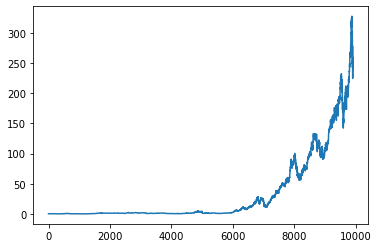

In [114]:
plt.plot(stocks['AAPL']['Close'])

In [115]:
def moving_average(ts, window):
    result = np.array([])
    for i in range(len(ts) - window):
        result = np.append(result, np.mean(ts[i:i+window]))
    return result

In [116]:
def median_filter(ts, window):
    result = np.array([])
    for i in range(len(ts) - window):
        result = np.append(result, np.median(ts[i:i+window]))
    return result

In [117]:
def average_ds(ts, window):
    result = np.array([])
    for i in range(int(len(ts)/window)):
        result = np.append(result, np.mean(ts[i*window : (i+1)*window]))
    return result

In [118]:
def median_ds(ts, window):
    result = np.array([])
    for i in range(int(len(ts)/window)):
        result = np.append(result, np.median(ts[i*window : (i+1)*window]))
    return result

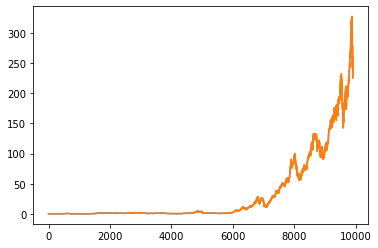

In [271]:
plt.plot(moving_average(stocks['AAPL']['Close'], 7))
plt.plot(stocks['AAPL']['Close'])

In [318]:
ts = stocks['TSLA']['Close']
ts = np.array(ts).reshape(-1,1)

In [319]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(ts)

In [320]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [321]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
        
look_back = 7
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [322]:
import keras
from keras import layers

inputs = keras.Input(shape=(look_back,1), dtype="float32")
x = layers.LSTM(4, return_sequences=False)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

Epoch 1/5
1957/1957 - 4s - loss: 0.0038
Epoch 2/5
1957/1957 - 3s - loss: 1.6194e-04
Epoch 3/5
1957/1957 - 4s - loss: 1.5297e-04
Epoch 4/5
1957/1957 - 5s - loss: 1.2734e-04
Epoch 5/5
1957/1957 - 4s - loss: 1.1490e-04


In [311]:
def rmse(a, b):
    return math.sqrt(mean_squared_error(a, b))

def plot_predictions(trainPredict, testPredict, dataset):
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    plt.plot(scaler.inverse_transform(dataset))
    plt.plot(trainPredictPlot)
    plt.plot(testPredictPlot)
    plt.show()

Train Score: 0.47 RMSE
Test Score: 11.97 RMSE
[ -79.16649   -79.37078   -79.955345 ... -221.07047  -221.87442
 -223.66074 ]


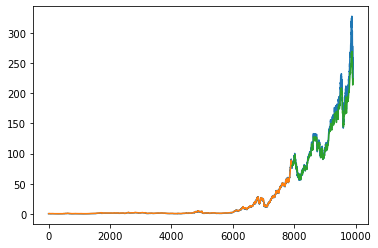

In [315]:
trainPredict = scaler.inverse_transform(model.predict(trainX))
trainTruth = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(model.predict(testX))
testTruth = scaler.inverse_transform([testY])


trainScore = rmse(trainTruth[0], trainPredict[:,0])
print('Train Score: %.2f RMSE' % (trainScore))
testScore = rmse(testTruth[0], testPredict[:,0])
print('Test Score: %.2f RMSE' % (testScore))

print(testY[0] - testPredict[:,0])

plot_predictions(trainPredict, testPredict, dataset)

In [316]:
diffTruth = trainTruth[0,1:] - trainTruth[0,:-1]
diffPredict = trainPredict[1:,0] - trainPredict[:-1,0]

# diffPredict.shape

changePercentError = (diffTruth - diffPredict) / diffTruth

<ipython-input-316-6a8b8cf9383b>:6: RuntimeWarning: divide by zero encountered in true_divide
  changePercentError = (diffTruth - diffPredict) / diffTruth


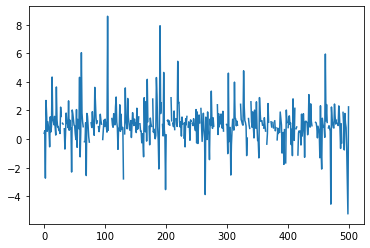

In [317]:
plt.plot(changePercentError[:500])

In [293]:
un_inversed = np.array([model.predict(testX[:look_back])])
inversed = np.array([scaler.inverse_transform(un_inversed[0])])
_range = 1000

for i in range(_range):
    pred = model.predict(un_inversed[-look_back:].reshape(1,look_back,1))
    un_inversed = np.append(un_inversed, pred)
    inversed = np.append(inversed, scaler.inverse_transform(pred))
    
    if i % 100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800
900


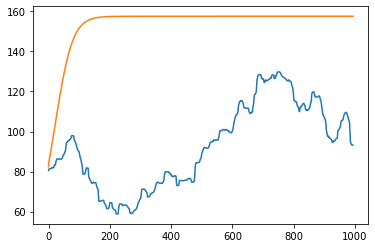

In [294]:
plt.plot(testTruth.reshape(testTruth.shape[1],)[look_back-1:_range])
plt.plot(inversed[look_back-1:_range])